In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
data = pd.read_csv(r"C:\Users\huynh\Downloads\Dự án 1\Data_Predict.csv")
data.head(5)

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,ProductSubcategoryKey,ProductSKU,ModelName,ProductColor,ProductSize,ProductStyle,ProductCost,ProductPrice,TotalRevenue
0,1/1/2020,9/21/2019,SO45080,332,14657,1,1,1,2,BK-R50B-58,Road-650,Black,58,U,413.1463,699.0982,699.0982
1,1/1/2020,12/5/2019,SO45079,312,29255,4,1,1,2,BK-R93R-48,Road-150,Red,48,U,2171.2942,3578.2700,3578.2700
2,1/1/2020,10/29/2019,SO45082,350,11455,9,1,1,1,BK-M82B-44,Mountain-100,Black,44,U,1898.0944,3374.9900,3374.9900
3,1/1/2020,11/16/2019,SO45081,338,26782,6,1,1,2,BK-R50B-44,Road-650,Black,44,U,413.1463,699.0982,699.0982
4,1/2/2020,12/15/2019,SO45083,312,14947,10,1,1,2,BK-R93R-48,Road-150,Red,48,U,2171.2942,3578.2700,3578.2700


In [3]:
data.dtypes

OrderDate                 object
StockDate                 object
OrderNumber               object
ProductKey                 int64
CustomerKey                int64
TerritoryKey               int64
OrderLineItem              int64
OrderQuantity              int64
ProductSubcategoryKey      int64
ProductSKU                object
ModelName                 object
ProductColor              object
ProductSize               object
ProductStyle              object
ProductCost              float64
ProductPrice             float64
TotalRevenue             float64
dtype: object

In [4]:
data['OrderDate'] = data['OrderDate'].astype('datetime64[s]')

In [5]:
data['OrderNumber'] = data['OrderNumber'].astype(str)

In [6]:
data.dtypes

OrderDate                datetime64[s]
StockDate                       object
OrderNumber                     object
ProductKey                       int64
CustomerKey                      int64
TerritoryKey                     int64
OrderLineItem                    int64
OrderQuantity                    int64
ProductSubcategoryKey            int64
ProductSKU                      object
ModelName                       object
ProductColor                    object
ProductSize                     object
ProductStyle                    object
ProductCost                    float64
ProductPrice                   float64
TotalRevenue                   float64
dtype: object

Đề xuất đặc trưng cho phân cụm:
Recency: Số ngày kể từ lần mua gần nhất.
Frequency: Số lần mua hàng (số hóa đơn).
Monetary: Tổng giá trị đơn hàng (Quantity × UnitPrice).

In [7]:
current_date = data['OrderDate'].max()

In [8]:
rfm = data.groupby('CustomerKey').agg({
    'OrderDate': lambda x: (current_date - x.max()).days,
    'OrderNumber': 'count',
    'OrderQuantity': lambda x: (x * data.loc[x.index, 'ProductPrice']).sum()
}).reset_index()

In [9]:
rfm.columns = ['CustomerKey', 'Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm > 0]

In [10]:
rfm = rfm.dropna()


In [11]:
scaler = StandardScaler()
scaler_data = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [12]:
kmean = KMeans(n_clusters= 3, random_state= 50)
rfm['Cluster']  = kmean.fit_predict(scaler_data)

In [13]:
rfm.head(5)

,CustomerKey,Recency,Frequency,Monetary,Cluster
0,11000,238.0,7,4656.3896,0
1,11001,18.0,10,2821.2122,0
2,11002,307.0,3,4466.8124,0
3,11003,231.0,8,4532.9866,0
4,11004,240.0,5,4568.0838,0


In [14]:
cluster_summmary = rfm.groupby('Cluster').mean()
cluster_summmary

,CustomerKey,Recency,Frequency,Monetary
Cluster,,,,
0,16644.593740,131.922389,5.366337,4751.505303
1,20447.356523,83.059199,2.936340,638.574904
2,21535.133670,278.118350,2.473737,783.691692


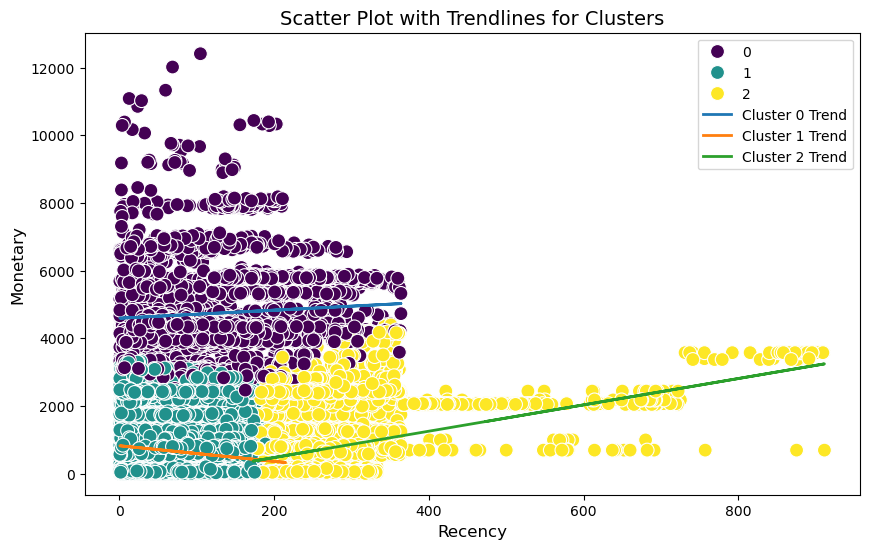

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=100)

for cluster in rfm['Cluster'].unique():
    cluster_data = rfm[rfm['Cluster'] == cluster]
    x = cluster_data['Recency']
    y = cluster_data['Monetary']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), label=f'Cluster {cluster} Trend', linewidth=2)

plt.title('Scatter Plot with Trendlines for Clusters', fontsize=14)
plt.xlabel('Recency', fontsize=12)
plt.ylabel('Monetary', fontsize=12)
plt.legend()
plt.show()



In [25]:
customer = rfm[rfm['Cluster'] == 1].sort_values(by='Monetary', ascending= False).head(10)

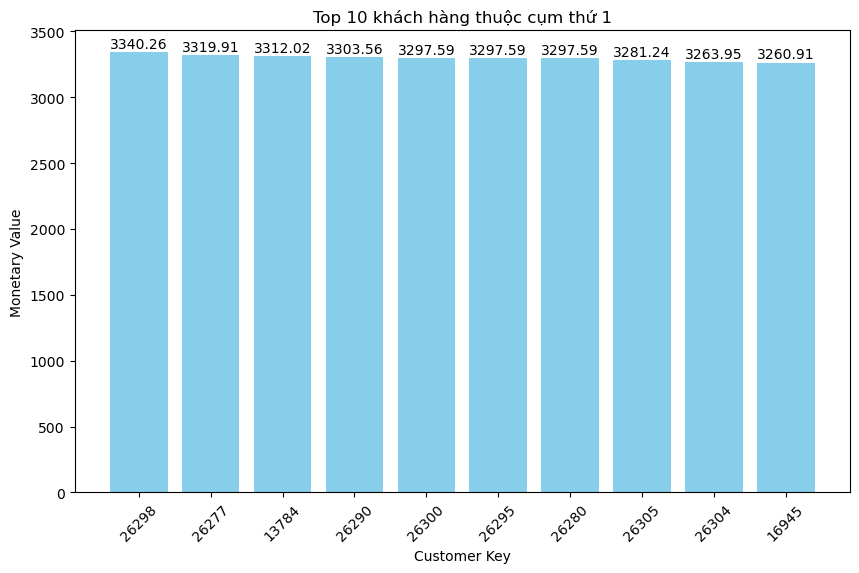

In [ ]:

plt.figure(figsize=(10, 6))
bars = plt.bar(customer['CustomerKey'].astype(str), customer['Monetary'], color='skyblue')


for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 10, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Customer Key')
plt.ylabel('Monetary Value')
plt.title('Top 10 khách hàng thuộc cụm thứ 1')
plt.xticks(rotation=45)
plt.show()